# Endpoint Formulation through Machine Learning with SQL

 SQL can be used to deploy ML endpoints by using algorithms calable directly from SQL. This leverages already accepted frameworks like SQL to develop endpoint strategy. This approach presents an advantage as superivsed, unsupervised and time series methods and functions can be used to suit different applications like anamoly detection, explanability and hyperparameter tuning. Here the approach is used to create a logistic regression model.

## Setting Up

In [1]:
REGION = 'us-central1'
PROJECT_ID='mlopstqc'
DATANAME = 'leaktest'
NOTEBOOK = '4'

# Model Training
VAR_TARGET = 'TestPressureMbar'
VAR_OMIT = 'transaction_id'

In [2]:
from google.cloud import bigquery


In [3]:
bigquery = bigquery.Client()

# Training the model

In [22]:
query = f"""
CREATE OR REPLACE MODEL `{DATANAME}.{DATANAME}_lr`
OPTIONS
    (model_type = 'BOOSTED_TREE_REGRESSOR' ,
        auto_class_weights = TRUE,
        input_label_cols = ['{VAR_TARGET}'],
        data_split_col = 'custom_splits',
        data_split_method = 'CUSTOM'
    ) AS
SELECT * EXCEPT({','.join(VAR_OMIT.split())}, splits),
    CASE
        WHEN splits = 'TRAIN' THEN FALSE
        ELSE TRUE
    END AS custom_splits
FROM `{DATANAME}.{DATANAME}_prepped`
WHERE splits != 'TEST'
"""
job = bigquery.query(query = query)
job.result()

In [23]:
(job.ended-job.started).total_seconds()


531.364

In [24]:
bigquery.query(query=f"SELECT * FROM ML.TRAINING_INFO(MODEL `{DATANAME}.{DATANAME}_lr`) ORDER BY iteration").to_dataframe()


,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,1,12402.00,12528.30,0.3,132485
1,0,2,9202.02,9337.45,0.3,70
2,0,3,7126.56,7269.67,0.3,53
3,0,4,5846.11,5993.50,0.3,12286
4,0,5,5102.54,5249.90,0.3,98
5,0,6,4695.19,4839.06,0.3,56
6,0,7,4481.93,4620.70,0.3,60
7,0,8,4373.65,4507.33,0.3,60
8,0,9,4319.60,4448.92,0.3,56
9,0,10,4292.81,4418.74,0.3,40


## Evaluating the Model

In [25]:
query = f"""
SELECT 'TRAIN' as SPLIT, * FROM ML.EVALUATE (MODEL `{DATANAME}.{DATANAME}_lr`,
    (SELECT * FROM `{DATANAME}.{DATANAME}_prepped` WHERE SPLITS='TRAIN'))
UNION ALL
SELECT 'TEST' as SPLIT, * FROM ML.EVALUATE (MODEL `{DATANAME}.{DATANAME}_lr`,
    (SELECT * FROM `{DATANAME}.{DATANAME}_prepped` WHERE SPLITS='TEST'))
"""
bigquery.query(query = query).to_dataframe()

,SPLIT,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,TEST,1819.772789,1.705208e+07,0.033509,602.448242,0.004571,0.013534
1,TRAIN,1883.700670,1.842841e+07,0.035030,602.448242,0.010920,0.022792


In [33]:
query = f"""
SELECT *
FROM ML.EVALUATE (MODEL `{DATANAME}.{DATANAME}_lr`,(
    SELECT *
    FROM `{DATANAME}.{DATANAME}_prepped`
    WHERE splits = 'TRAIN')
  )
"""
bigquery.query(query = query).to_dataframe()

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,1883.70067,1.842841e+07,0.03503,602.448242,0.01092,0.022792


In [34]:
query = f"""
SELECT *
FROM ML.EVALUATE (MODEL `{DATANAME}.{DATANAME}_lr`,(
    SELECT *
    FROM `{DATANAME}.{DATANAME}_prepped`
    WHERE splits = 'VALIDATE')
  )
"""
bigquery.query(query = query).to_dataframe()

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,1972.955142,1.952523e+07,0.037586,602.448242,0.008022,0.023999


In [38]:
query = f"""
SELECT *
FROM ML.EVALUATE (MODEL `{DATANAME}.{DATANAME}_lr`,(
    SELECT *
    FROM `{DATANAME}.{DATANAME}_prepped`
    WHERE splits = 'TEST')
  )
"""
bigquery.query(query = query).to_dataframe()

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,1819.772789,1.705208e+07,0.033509,602.448242,0.004571,0.013534


## Predictions

In [28]:
query = f"""
SELECT *
FROM ML.PREDICT (MODEL `{DATANAME}.{DATANAME}_lr`,(
    SELECT *
    FROM `{DATANAME}.{DATANAME}_prepped`
    WHERE splits = 'TEST')
  )
"""
pred = bigquery.query(query = query).to_dataframe()

In [29]:
pred.columns

Index(['predicted_TestPressureMbar', 'TestVolumeLitre', 'AlarmDiffPressure',
       'TestPressureMbar', 'transaction_id', 'splits'],
      dtype='object')

In [32]:
pred[[VAR_TARGET, f'predicted_{VAR_TARGET}', f'predicted_{VAR_TARGET}_probs', 'splits']].head()


KeyError: "['predicted_TestPressureMbar_probs'] not in index"

In [31]:
exec('temp = pred.predicted_'+VAR_TARGET+'_probs[0]')
[sorted(x, key = lambda x: x['label']) for x in [temp]]

AttributeError: 'DataFrame' object has no attribute 'predicted_TestPressureMbar_probs'

## Interpretation

In [39]:
query = f"""
SELECT *
FROM ML.EXPLAIN_PREDICT (MODEL `{DATANAME}.{DATANAME}_lr`,(
    SELECT *
    FROM `{DATANAME}.{DATANAME}_prepped`
    WHERE splits = 'TEST'), STRUCT(10 as top_k_features)
  )
"""
explain = bigquery.query(query = query).to_dataframe()

In [40]:
explain.head()

,predicted_TestPressureMbar,top_feature_attributions,baseline_prediction_value,prediction_value,approximation_error,TestVolumeLitre,AlarmDiffPressure,TestPressureMbar,transaction_id,splits
0,15470.639648,"[{'feature': 'AlarmDiffPressure', 'attribution...",16150.113281,15470.639053,0.0,0.2,500,12800,68cfe17b-33f6-4240-9254-d77514feb083,TEST
1,17199.671875,"[{'feature': 'TestVolumeLitre', 'attribution':...",16150.113281,17199.672638,0.0,10.0,320,12800,e6cc26be-a050-4c91-99cf-52c2dcea0924,TEST
2,16102.448242,"[{'feature': 'TestVolumeLitre', 'attribution':...",16150.113281,16102.447571,0.0,0.1,320,12800,b5e82b71-f62a-400a-9cf1-f551b2b57bf9,TEST
3,16102.448242,"[{'feature': 'TestVolumeLitre', 'attribution':...",16150.113281,16102.447571,0.0,0.1,320,12800,d2f9cc2b-4aed-4734-a723-17b44020021b,TEST
4,17049.875000,"[{'feature': 'TestVolumeLitre', 'attribution':...",16150.113281,17049.876022,0.0,0.4,500,19200,eb69188a-1ea3-420d-b8fd-d33446aa65ac,TEST


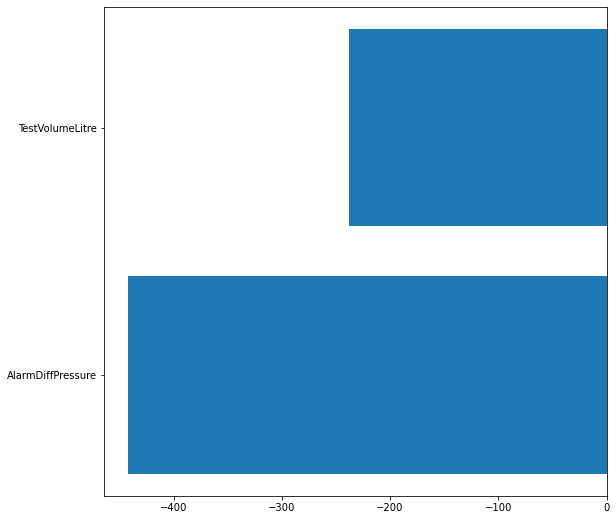

In [41]:
import matplotlib.pyplot as plt
features = []
scores = []
for k in explain.iloc[0]['top_feature_attributions']:
    features.append(k['feature'])
    scores.append(k['attribution'])
features = [x for _, x in sorted(zip(scores, features))]
scores = sorted(scores)
fig, ax = plt.subplots()
fig.set_size_inches(9, 9)
ax.barh(features, scores)
fig.show()